## Import Dependencies

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tableone import TableOne
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, auc
import os
import pydata_google_auth

## Authenticate with GCP to access MIMIC

In [2]:
project_id = 'mimic-369422'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
    use_local_webserver=False
)

def run_query(query):
    return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      credentials=credentials,
      configuration={'query': {
          'useLegacySql': False
      }})

## Cohort Curation
#### Inclusion/Exclusion Criteria
1. Patients > 18
2. 1st ICU stay
3. Measurement of creatinine and urine ouput within 24 hours
4. aki stage 2 
5. not a CEER ICD 10-N18
6. No DNR

#### AKI Stage > 0

In [3]:
# Base the cohort off of patients with aki_stage > 0.
aki = run_query(
    """SELECT * FROM `physionet-data.mimiciv_derived.kdigo_stages` WHERE aki_stage <> 0"""
)

In [4]:
aki_pats = aki['subject_id'].unique()
len(aki_pats)

33146

#### First ICU Stay

In [5]:
# Get the ICU stays of the AKI patients and select the first one.
icustays = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_icu.icustays` WHERE subject_id IN {str(tuple(aki_pats))}"""
)
icustays.shape

(53573, 8)

In [6]:
# Returns the first ICU stay for each patient.
def get_first_icu_stay(df):
    min_stay = df.groupby(by='subject_id')['intime'].min().reset_index()
    result = df.merge(min_stay)
    return result

icu_first = get_first_icu_stay(icustays)
icu_first.shape

(33146, 8)

In [7]:
icu_first.nunique()

subject_id        33146
hadm_id           33146
stay_id           33146
first_careunit        9
last_careunit         9
intime            33146
outtime           33146
los               32077
dtype: int64

In [8]:
aki_icu = aki.merge(icu_first, on=['subject_id', 'hadm_id', 'stay_id'])
aki_icu.shape

(562149, 18)

aki_icu

In [9]:
aki_icu.nunique()

subject_id              29945
hadm_id                 29945
stay_id                 29945
charttime              447065
creat_low_past_7day       184
creat_low_past_48hr       191
creat                     220
aki_stage_creat             4
uo_rt_6hr               14461
uo_rt_12hr              17428
uo_rt_24hr              20280
aki_stage_uo                4
aki_stage                   3
first_careunit              9
last_careunit               9
intime                  29945
outtime                 29945
los                     29095
dtype: int64

#### Filter out patients with ICD10 code N18

In [10]:
# Query diagnosis tables for patients in aki which have diagnosis codes with the N18 prefix.
diag_n18 = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_hosp.diagnoses_icd` WHERE subject_id IN {str(tuple(aki_pats))} 
    AND icd_code LIKE 'N18%'
    """
)
diag_n18.shape

(13687, 5)

In [11]:
diag_n18.nunique()

subject_id      4906
hadm_id        13617
seq_num           39
icd_code           7
icd_version        1
dtype: int64

In [12]:
# Select admittimes for N18 diagnosis.
diag_n18_encounters = diag_n18['hadm_id'].unique()
diag_n18_admissions = run_query(
    f"""
    SELECT hadm_id, admittime FROM `physionet-data.mimiciv_hosp.admissions` WHERE hadm_id IN {str(tuple(diag_n18_encounters))} 
    """
)
diag_n18_admissions.shape

(13617, 2)

In [13]:
diag_n18_dt = diag_n18.merge(diag_n18_admissions, on='hadm_id')
diag_n18_dt.shape

(13687, 6)

In [14]:
# Find patients to drop.
n18_drop_candidates = diag_n18_dt.merge(aki_icu, on=['subject_id', 'hadm_id'])
n18_drop = n18_drop_candidates[n18_drop_candidates['admittime'] >= n18_drop_candidates['intime']]
n18_drop_pats = n18_drop['subject_id'].unique()
len(n18_drop_pats)

1

In [15]:
aki_icu_no_n18 = aki_icu[~aki_icu['subject_id'].isin(n18_drop_pats)]
aki_icu_no_n18_enc = aki_icu_no_n18['hadm_id'].unique()

#### Filter out patients with DNR request

In [16]:
# Get patients with DNR in the current cohort.
dnr = run_query(
    f"""SELECT hadm_id from `physionet-data.mimiciv_icu.chartevents` WHERE itemid=22378 or itemid=228687 
    AND hadm_id IN {str(tuple(aki_icu_no_n18_enc))}"""
)
dnr.shape

(2413, 1)

In [17]:
aki_no_dnr = aki_icu_no_n18[~aki_icu_no_n18.isin(dnr['hadm_id'].values)]
aki_no_dnr.shape

(562132, 18)

#### Creatinine and Urine Output within 24 hours of admission

In [18]:
aki_no_dnr_sid = aki_no_dnr['stay_id'].unique()

In [19]:
# Get creatinine and urine output values for the current cohort.
creatinine = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_creatinine` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}"""
)
uo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_uo` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}
    """
)

In [20]:
# Find stay_ids that do not have a creatinine or uo value within 24 hours.
cohort_sid_intime = aki_no_dnr[['stay_id', 'intime']].drop_duplicates()
cohort_sid_intime.shape

(29944, 2)

In [21]:
cohort_sid_intime.nunique()

stay_id    29944
intime     29944
dtype: int64

In [22]:
# Merge with intime
creatinine_icu = cohort_sid_intime.merge(creatinine, on='stay_id', how='left')
uo_icu = cohort_sid_intime.merge(uo, on='stay_id', how='left')
print(creatinine_icu.nunique())
print(uo_icu.nunique())

stay_id                 29944
intime                  29944
hadm_id                 29944
charttime              294632
creat                     288
creat_low_past_48hr       252
creat_low_past_7day       245
dtype: int64
stay_id              29944
intime               29944
charttime           874952
weight                1708
urineoutput_6hr       3059
urineoutput_12hr      5104
urineoutput_24hr      8833
uo_rt_6hr            67925
uo_rt_12hr           61784
uo_rt_24hr           58085
uo_tm_6hr              301
uo_tm_12hr             661
uo_tm_24hr            1381
dtype: int64


In [23]:
# Calculate delta between intime and charttime in days.
creatinine_icu['delta_days'] = (creatinine_icu['charttime'] - creatinine_icu['intime']) / np.timedelta64(1, 'D')
uo_icu['delta_days'] = (uo_icu['charttime'] - uo_icu['intime']) / np.timedelta64(1, 'D')

In [24]:
creatinine_icu['delta_days'].describe()

count    296528.000000
mean          3.811885
std           7.433187
min          -6.999803
25%           0.111493
50%           1.500000
75%           5.127827
max         101.209722
Name: delta_days, dtype: float64

In [25]:
uo_icu['delta_days'].describe()

count    2.004681e+06
mean     5.443660e+00
std      7.444055e+00
min     -3.001042e+01
25%      1.103657e+00
50%      2.807419e+00
75%      6.826088e+00
max      1.015424e+02
Name: delta_days, dtype: float64

In [26]:
# Filter for measurements within 48 hours.
creatinine_icu_48 = creatinine_icu[(creatinine_icu['delta_days'] >= 0) & (creatinine_icu['delta_days'] <= 2)]
uo_icu_48 = uo_icu[(uo_icu['delta_days'] >= 0) & (uo_icu['delta_days'] <= 2)]

In [27]:
# Use set intersection to find ids that match by criterion. 
sids_48 = list(set(creatinine_icu_48['stay_id'].unique()).intersection(set(uo_icu_48['stay_id'].unique())))
len(sids_48)

29109

In [28]:
# Stays lost
len(aki_no_dnr_sid) - len(sids_48)

835

In [29]:
aki_creat_uo_48 = aki_no_dnr[aki_no_dnr['stay_id'].isin(sids_48)].reset_index(drop=True)
aki_creat_uo_48.shape

(555607, 18)

#### Patients greater than 18

In [30]:
aki_creat_uo_48_pats = aki_creat_uo_48['subject_id'].unique()

In [31]:
# Query patients in our current cohort under 18.
demo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_hosp.patients` WHERE subject_id IN {str(tuple(aki_creat_uo_48_pats))} """
)

In [32]:
demo_18 = demo[demo['anchor_age'] < 18]

In [33]:
# No patients match so we can ignore this criteria.
demo_18.shape[0]

0

#### Filter to a single sample per patient.
Idea: Max AKI stage in the 1st 48 hours of the stay.
If duplicates, take the one closest to the intime.

In [34]:
# Calculate delta days.
aki_creat_uo_48['delta_hours_aki'] = (aki_creat_uo_48['charttime'] - aki_creat_uo_48['intime']) / np.timedelta64(1, 'h')

In [35]:
aki_creat_uo_48['delta_hours_aki'].describe()

count    555607.000000
mean        112.721877
std         171.001350
min        -159.816944
25%          23.550000
50%          51.166667
75%         127.566667
max        2284.089722
Name: delta_hours_aki, dtype: float64

In [36]:
cohort_48 = aki_creat_uo_48[(aki_creat_uo_48['delta_hours_aki'] >= 0) & (aki_creat_uo_48['delta_hours_aki'] <= 12)].reset_index(drop=True)

In [37]:
max_aki_48 = cohort_48.groupby(by='stay_id')['aki_stage'].max().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [38]:
cohort_max_aki = aki_creat_uo_48.merge(max_aki_48)

In [39]:
# Select the min chart time.
min_chart = cohort_max_aki.groupby('stay_id')['charttime'].min().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [40]:
cohort = cohort_max_aki.merge(min_chart)

In [41]:
# Drop NaN on hadm_id as NaN hadm_id's represent outpatients.
cohort = cohort.dropna(subset=['hadm_id'])
cohort.shape

(12688, 19)

## Add Covariates

#### Labs
- K+
- pH
- BUN
- HCO3

In [42]:
cohort_enc = cohort['hadm_id'].unique()
labs = run_query(
    f"""SELECT * FROM (select l.*, d.label from `physionet-data.mimiciv_hosp.labevents` AS l
        JOIN `physionet-data.mimiciv_hosp.d_labitems` d ON l.itemid = d.itemid WHERE 
        l.itemid IN (51006, 50822, 50971, 50810, 51221, 50912, 50862, 50820, 50882, 50803)
        ) 
        WHERE hadm_id IN {str(tuple(cohort_enc))}"""
)

In [43]:
labs.shape

(1289950, 16)

In [44]:
cohort_ts = cohort[['stay_id', 'hadm_id', 'intime', 'outtime']].drop_duplicates()

In [45]:
# Convert dates to datetime.
cohort_ts['intime'] = pd.to_datetime(cohort_ts['intime'])
cohort_ts['outtime'] = pd.to_datetime(cohort_ts['outtime'])
labs['charttime'] = pd.to_datetime(labs['charttime'])

In [46]:
# Filter labs to only keep those whose charttime is between an admissions intime and outtime. 
labs_merged = labs.merge(cohort_ts, on='hadm_id')
labs_filt = labs_merged[(labs_merged['charttime'] >= labs_merged['intime']) & (labs_merged['charttime'] <= labs_merged['outtime'])]
labs_filt.shape

(710056, 19)

In [47]:
# Pivot table to get the min and max values of labs. 
lab_description = pd.pivot_table(labs, values=['valuenum'], index=['hadm_id'], columns=['label'], aggfunc=[np.nanmin, np.nanmax])
lab_description = lab_description.reset_index()
# Restore correct columns.
cols = ["_".join(x) for x in list(lab_description)]
cols[0] = 'hadm_id'
lab_description.columns = cols

In [48]:
lab_description.head()

,hadm_id,nanmin_valuenum_Albumin,nanmin_valuenum_Bicarbonate,"nanmin_valuenum_Calculated Bicarbonate, Whole Blood",nanmin_valuenum_Creatinine,nanmin_valuenum_Hematocrit,"nanmin_valuenum_Hematocrit, Calculated",nanmin_valuenum_Potassium,"nanmin_valuenum_Potassium, Whole Blood",nanmin_valuenum_Urea Nitrogen,...,nanmax_valuenum_Albumin,nanmax_valuenum_Bicarbonate,"nanmax_valuenum_Calculated Bicarbonate, Whole Blood",nanmax_valuenum_Creatinine,nanmax_valuenum_Hematocrit,"nanmax_valuenum_Hematocrit, Calculated",nanmax_valuenum_Potassium,"nanmax_valuenum_Potassium, Whole Blood",nanmax_valuenum_Urea Nitrogen,nanmax_valuenum_pH
0,20000094,3.1,19.0,NaN,3.8,40.1,NaN,4.3,NaN,99.0,...,3.6,28.0,NaN,3.9,42.1,NaN,4.6,NaN,99.0,7.41
1,20001305,2.6,21.0,NaN,0.8,31.4,NaN,4.1,NaN,47.0,...,2.6,25.0,NaN,1.2,34.5,NaN,4.7,NaN,59.0,7.46
2,20001361,3.0,20.0,NaN,1.6,30.6,NaN,3.4,NaN,24.0,...,3.2,26.0,NaN,4.2,37.2,NaN,5.8,NaN,49.0,7.48
3,20001729,3.5,17.0,NaN,1.1,24.1,26.0,3.7,3.3,10.0,...,3.5,33.0,NaN,3.7,38.3,28.0,5.7,4.5,58.0,7.48
4,20001770,2.0,15.0,NaN,0.7,19.9,NaN,3.4,3.4,9.0,...,3.0,22.0,NaN,1.7,28.4,NaN,5.2,3.4,23.0,7.26


In [49]:
cohort_icu_labs = cohort.merge(lab_description, on='hadm_id')

In [50]:
cohort_icu_labs.shape

(12683, 39)

#### SOFA Score
Select SOFA closest to icu admission.

In [51]:
cohort_sid = cohort_icu_labs['stay_id'].unique()

In [52]:
# Query SOFA scores for the selected stays.
sofa = run_query(
    f"""SELECT stay_id, hr, starttime, endtime, sofa_24hours
    FROM `physionet-data.mimiciv_derived.sofa` WHERE stay_id IN {str(tuple(cohort_sid))}"""
)

In [53]:
sofa.shape

(1377183, 5)

In [54]:
sofa_48 = sofa[sofa['hr'] <= 48]

In [55]:
sofa_48_min = dict(sofa_48.groupby(by='stay_id')['hr'].min())

In [56]:
sofa['min_hour'] = sofa['stay_id'].map(sofa_48_min)

In [57]:
sofa = sofa[sofa['min_hour'] == sofa['hr']]
sofa.shape

(12683, 6)

In [58]:
cohort_sofa = cohort_icu_labs.merge(sofa, on='stay_id', how='left')
cohort_sofa.shape

(12683, 44)

#### Antibiotics

In [59]:
antib = run_query(
    f"""
    SELECT a.stay_id, a.starttime, a.route, a.antibiotic FROM `physionet-data.mimiciv_derived.antibiotic` AS a
    where (a.antibiotic like "Vancomycin" or a.antibiotic like 
    "Gentamicin" or a.antibiotic like "Vancocin" 
    or a.antibiotic like "Gentamicin (Bulk)" or a.antibiotic like 'NEO*IV*Gentamicin' 
    or a.antibiotic like 'NEO*IV*Vancomycin' or a.antibiotic like 'Gentamicin Sulfate') AND
    a.stay_id IN {str(tuple(cohort_sid))}
    """
)
antib.shape

(18244, 4)

In [60]:
antib['antibiotic'] = 1

In [61]:
cohort_stay_intime = cohort_sofa[['stay_id', 'intime']].drop_duplicates()
antib['starttime'] = pd.to_datetime(antib['starttime'])
antib = antib.dropna(subset='stay_id')
antib_intime_stayid = cohort_stay_intime.merge(antib, on='stay_id')
antib_intime_stayid['delta_days'] = (antib_intime_stayid['starttime'] - antib_intime_stayid['intime']) / np.timedelta64(1, 'D')
antib_intime_stayid_48 = antib_intime_stayid[antib_intime_stayid['delta_days'] <= 2]
antib_intime_stayid_48 = antib_intime_stayid_48.drop_duplicates(subset=['stay_id'])
antib_intime_stayid_48 = antib_intime_stayid_48[['stay_id', 'antibiotic']]
cohort_antib = cohort_sofa.merge(antib_intime_stayid_48, on='stay_id', how='left')
cohort_antib['antibiotic'].fillna(0, inplace=True)
cohort_antib.shape

(12683, 45)

In [62]:
cohort_antib['antibiotic'].value_counts()

0.0    7416
1.0    5267
Name: antibiotic, dtype: int64

#### Sepsis

In [63]:
sepsis = run_query(
    f"""
    SELECT stay_id, sepsis3 FROM `physionet-data.mimiciv_derived.sepsis3` WHERE
    stay_id IN {str(tuple(cohort_sid))}
    """
)
sepsis.shape

(7643, 2)

In [64]:
sepsis.drop_duplicates(inplace=True)
sepsis.shape

(7643, 2)

In [65]:
cohort_sepsis = cohort_antib.merge(sepsis, on='stay_id', how='left')
cohort_sepsis['sepsis3'].value_counts(dropna=False)
cohort_sepsis['sepsis3'].fillna(False, inplace=True)
cohort_sepsis.shape

(12683, 46)

#### Vitals
- Heart Rate
- MBP
- MBP_NI
- Resp Rate
- SPo2

In [66]:
# Query requested vitals attributes for the cohort.
cohort_sids = cohort_sepsis['stay_id'].unique()
vitals = run_query(
    f"""
    SELECT stay_id, charttime, heart_rate, mbp, mbp_ni, resp_rate, spo2
    FROM `physionet-data.mimiciv_derived.vitalsign` WHERE stay_id IN 
    {str(tuple(cohort_sids))}
    """
)

In [67]:
# Get min and max vitals.
agg_cols = ['heart_rate', 'mbp', 'mbp_ni', 'resp_rate', 'spo2']
vitals_min = vitals.groupby('stay_id')[agg_cols].min().reset_index()
vitals_min.rename(dict(zip(agg_cols, ['min_' + x for x in agg_cols])), axis=1, inplace=True)
vitals_max = vitals.groupby('stay_id')[agg_cols].max().reset_index()
vitals_max.rename(dict(zip(agg_cols, ['max_' + x for x in agg_cols])), axis=1, inplace=True)

In [68]:
cohort_vitals = cohort_sepsis.merge(vitals_min, on='stay_id', how='left')
cohort_vitals = cohort_vitals.merge(vitals_max, on='stay_id', how='left')

In [69]:
cohort_vitals.shape

(12683, 56)

#### Comorbdities
- CKD
- Hypotension
- Heart Failure
- Diabetes

In [70]:
# Query all icd codes for our cohort.
cohort_enc = cohort_vitals['hadm_id'].unique()
icdcodes = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_hosp.diagnoses_icd` WHERE 
    hadm_id IN {str(tuple(cohort_enc))}
    """
)
icdcodes.shape

(249363, 5)

In [71]:
"""
Functions for calculating comorbidities based on ICD9/10 codes.
"""
def is_DM(row):
    
    if row.icd_version== 9:
        if row.icd_code == 7751:
            return 1 
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25000 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25033:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64800 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64804:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24900 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24931:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25040 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25093:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24940 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24991:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:       
        if row.icd_code.startswith('E08') or row.icd_code.startswith('E09') or row.icd_code.startswith('E10') or row.icd_code.startswith('E11') or row.icd_code.startswith('E12') or row.icd_code.startswith('E13'):
            return 1      
        else:
            return 0

def is_HF(row): #heart failure
    if row.icd_version== 9:
        if pd.to_numeric(row.icd_code, errors= "coerce") == 4280 or pd.to_numeric(row.icd_code, errors= "coerce") == 4281 or pd.to_numeric(row.icd_code, errors= "coerce") == 4289 or pd.to_numeric(row.icd_code, errors= "coerce")==39891:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42820 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42823:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42830 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42832:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42840 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42843:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I13') or row.icd_code.startswith('I11') or row.icd_code.startswith('I25') or row.icd_code.startswith('I46') or row.icd_code.startswith('I50') or row.icd_code.startswith('I42') or row.icd_code.startswith('I43')  or row.icd_code.startswith('I44'):
            return 1      
        else:
            return 0

# Hypertension -icd 9 and 10 
def is_Hypert(row): 
    
    l=[4010,4011,4019,4372,40200,40210,40290,40509,40519,40201,40211,40291,40310,40300,40390,40501,40511,
       40591,40301,40311,40391,40400,40410,40490,40401,40411,40491,40402,40412,40492,40403,40413,40493]
    
    if row.icd_version== 9:

        if pd.to_numeric(row.icd_code, errors= "coerce") in l:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64200 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64204:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64220 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64224:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64210 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64214:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64270 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64274:
            return 1   
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64290 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64294:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I10') or row.icd_code.startswith('I15') or row.icd_code.startswith('I16'):
            return 1      
        else:
            return 0

def is_CKD(row):
    if row.icd_version== 9:
        
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 5851 and pd.to_numeric(row.icd_code, errors= "coerce") <= 5856:
            return 1     
        if pd.to_numeric(row.icd_code, errors= "coerce") == 5859:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I12') or row.icd_code.startswith('I12') or row.icd_code.startswith('N01') or row.icd_code.startswith('N02') or row.icd_code.startswith('N03') or row.icd_code.startswith('N04') or row.icd_code.startswith('N05') or row.icd_code.startswith('N06') or row.icd_code.startswith('N07') or row.icd_code.startswith('N08') or row.icd_code.startswith('N11') or row.icd_code.startswith('N13')     or row.icd_code.startswith('N14') or row.icd_code.startswith('N15') or row.icd_code.startswith('N18') or row.icd_code.startswith('N19') or row.icd_code.startswith('N25') or row.icd_code.startswith('N26') or row.icd_code.startswith('N27') or row.icd_code.startswith('N28') or row.icd_code.startswith('N29'):
            return 1      
        else:
            return 0  

In [72]:
# Calculate binary labels on icd codes.
icdcodes['dm'] = icdcodes.apply(is_DM, axis=1)
icdcodes['heartfailure'] = icdcodes.apply(is_HF, axis=1)
icdcodes['hypertension'] = icdcodes.apply(is_Hypert, axis=1)
icdcodes['ckd'] = icdcodes.apply(is_CKD, axis=1)

In [73]:
# Get one value for every stay ID.
ckd   = icdcodes.groupby('hadm_id')['ckd'].max().reset_index()
dm    = icdcodes.groupby('hadm_id')['dm'].max().reset_index()
hyper = icdcodes.groupby('hadm_id')['hypertension'].max().reset_index()
hf    = icdcodes.groupby('hadm_id')['heartfailure'].max().reset_index()

In [74]:
# Construct comorbdities dataframe.
comorbidities = ckd.merge(dm, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hyper, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hf, on='hadm_id', how='left')
comorbidities = comorbidities.fillna(0)

In [75]:
cohort_covariates = cohort_vitals.merge(comorbidities, on='hadm_id', how='left')

## Merge with CRRT Labels
Criteria - Only consider patients that recieved CRRT after the first 12 hours and before the first 5 days of their ICU stay 

In [76]:
cohort_sid = cohort_covariates['stay_id'].unique()

In [77]:
crrt = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_derived.crrt` 
    WHERE stay_id IN {str(tuple(cohort_sid))}
    """
)
crrt.shape

(117037, 24)

In [78]:
cohort_ts = cohort_covariates[['stay_id', 'intime']].drop_duplicates()

In [79]:
crrt['charttime'] = pd.to_datetime(crrt['charttime'])
crrt_icu = crrt.merge(cohort_ts, on='stay_id')
crrt_icu['time_delta'] = (crrt_icu['charttime'] - crrt_icu['intime']) / np.timedelta64(1, 'h')
crrt_icu = crrt_icu[crrt_icu['charttime'] > crrt_icu['intime']].reset_index(drop=True)
min_crrt = crrt_icu.groupby('stay_id')['charttime'].min().reset_index()
crrt_min = crrt_icu.merge(min_crrt)
crrt_min.shape

(964, 26)

Text(0.5, 1.0, 'CRRT Incidence Distribution')

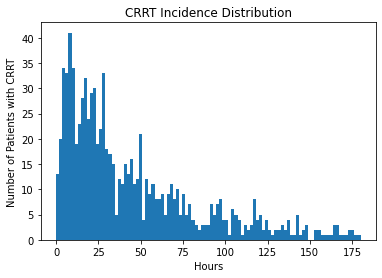

In [80]:
b= np.linspace(0, 180, 100)
plt.hist(crrt_min['time_delta'], bins=b)
plt.xlabel('Hours')
plt.ylabel('Number of Patients with CRRT')
plt.title('CRRT Incidence Distribution')

In [81]:
# Keep patients [0.5 days to 5 day window]
crrt_filt = crrt_min[(crrt_min['time_delta'] >= 12) &  (crrt_min['time_delta'] <= 120)].reset_index(drop=True)
crrt_filt.shape

(631, 26)

In [82]:
# Merge with CRRT Labels
crrt_filt['crrt'] = 1
crrt_filt = crrt_filt[['stay_id', 'crrt']].drop_duplicates()
cohort_final = cohort_covariates.merge(crrt_filt, on='stay_id', how='left')
cohort_final['crrt'].fillna(0, inplace=True)

#### Merge with Demographics

In [83]:
cohort_pats = cohort_final['subject_id'].unique()
demo = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.patients` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)
# Some demographic data is stored in admissions.
admissions = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.admissions` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)

In [84]:
cohort_final = cohort_final.merge(demo, on='subject_id')
cohort_final = cohort_final.merge(admissions, on=['subject_id', 'hadm_id'])

In [85]:
cohort_final.shape

(12683, 79)

In [86]:
cohort_final.to_csv('final_crrt_cohort.csv', index=False)

## Table 1

In [240]:
columns_all = ['first_careunit', 'creat_low_past_48hr', 'aki_stage', 'race','min_heart_rate',
 'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2',
 'ckd',
 'dm',
 'hypertension',
 'heartfailure',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
 'sepsis3',
 'sofa_24hours',
 'antibiotic',
 'gender']

numerical_all =[
    'creat_low_past_48hr',
    'min_heart_rate',
    'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2','nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
        'sofa_24hours',]

for col in numerical_all:
    cohort_final[col] = cohort_final[col].astype(np.float64)

categorical_all = [x for x in columns_all if x not in numerical_all]

tab = TableOne(cohort_final, columns=columns_all,categorical=categorical_all, groupby='crrt')

/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq

In [241]:
# Display entire dataframe.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 5)

In [242]:
tab

Grouped by crrt                                          
                                                                                                                Missing         Overall       0.0           1.0          
n                                                                                                                                       12683         12052           631
first_careunit, n (%)                                          Cardiac Vascular Intensive Care Unit (CVICU)          0            1845 (14.5)   1752 (14.5)     93 (14.7)
                                                               Coronary Care Unit (CCU)                                           1474 (11.6)   1393 (11.6)     81 (12.8)
                                                               Medical Intensive Care Unit (MICU)                                 2820 (22.2)   2612 (21.7)    208 (33.0)
                                                               Medical/Surgical Intensive Care Unit (MICU/SICU)                   2257 (17.8)   2161 (17.9)     96 (15.2)
                                                               Neuro Intermediate                                                    48 (0.4)      48 (0.4)              
                                                               Neuro Stepdown                                                        34 (0.3)      34 (0.3)              
                                                               Neuro Surgical Intensive Care Unit (Neuro SICU)                      256 (2.0)     250 (2.1)       6 (1.0)
                                                               Surgical Intensive Care Unit (SICU)                                1988 (15.7)   1898 (15.7)     90 (14.3)
                                                               Trauma SICU (TSICU)                                                1961 (15.5)   1904 (15.8)      57 (9.0)
creat_low_past_48hr, mean (SD)                                                                                    9466              1.9 (2.2)     1.8 (2.1)     2.9 (2.2)
aki_stage, n (%)                                               1                                                     0            5685 (44.8)   5526 (45.9)    159 (25.2)
                                                               2                                                                  6079 (47.9)   5745 (47.7)    334 (52.9)
                                                               3                                                                    919 (7.2)     781 (6.5)    138 (21.9)
race, n (%)                                                    AMERICAN INDIAN/ALASKA NATIVE                         0               27 (0.2)      26 (0.2)       1 (0.2)
                                                               ASIAN                                                                106 (0.8)     103 (0.9)       3 (0.5)
                                                               ASIAN - ASIAN INDIAN                                                  26 (0.2)      24 (0.2)       2 (0.3)
                                                               ASIAN - CHINESE                                                       95 (0.7)      91 (0.8)       4 (0.6)
                                                               ASIAN - KOREAN                                                         7 (0.1)       7 (0.1)              
                                                               ASIAN - SOUTH EAST ASIAN                                              35 (0.3)      33 (0.3)       2 (0.3)
                                                               BLACK/AFRICAN                                                         42 (0.3)      39 (0.3)       3 (0.5)
                                                               BLACK/AFRICAN AMERICAN                                               983 (7.8)     936 (7.8)      47 (7.4)
                                

In [243]:
tab.to_csv('tableone.csv')

## Model Training

#### Baseline model
No strategy to handle class imbalance

In [244]:
data = cohort_final.copy()

In [245]:
# Select variables for the model.
columns = [
 'min_spo2',
 'max_spo2',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
'ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure',
]
categorical = ['ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure'
]

numerical = [x for x in columns if x not in categorical]

In [272]:
def train_predict_lr(data, columns, numerical, categorical):
    sc = StandardScaler()
    oh = OneHotEncoder()
    
    train, test = train_test_split(data, test_size=0.3, random_state=2022, stratify=data['crrt'].ravel())
    
    X_train = train[columns].fillna(-1)
    X_test = test[columns].fillna(-1)
    y_train = train['crrt'].ravel()
    y_test = test['crrt'].ravel()
    
    
    X_num_train = sc.fit_transform(X_train[numerical])
    X_num_test = sc.transform(X_test[numerical])
    X_cat_train = X_train[categorical]
    X_cat_test = X_test[categorical]
    
    X_train_proc = np.hstack((X_num_train, X_cat_train))
    X_test_proc = np.hstack((X_num_test, X_cat_test))
    
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=2022)
    clf.fit(X_train_proc, y_train)
    print(dict(zip(columns, clf.coef_.ravel())))
    yHat = clf.predict_proba(X_test_proc)
    return test, y_test, yHat

In [273]:
_, y_test, yHat = train_predict_lr(data, columns, numerical, categorical)

{'min_spo2': -0.37609847486991616, 'max_spo2': 0.10334239504471104, 'nanmin_valuenum_Albumin': -0.4568752689485102, 'nanmin_valuenum_Creatinine': -0.11204266909153525, 'nanmin_valuenum_Hematocrit': -0.26901974999943146, 'nanmin_valuenum_Potassium': 0.2801555310759435, 'nanmin_valuenum_Potassium, Whole Blood': 0.22135601062016627, 'nanmin_valuenum_Urea Nitrogen': -0.5218626324990073, 'nanmin_valuenum_pH': -8.05142515033888, 'nanmax_valuenum_Albumin': 0.7401956965265231, 'nanmax_valuenum_Creatinine': 1.2063680201146387, 'nanmax_valuenum_Hematocrit': -0.09310382558872653, 'nanmax_valuenum_Hematocrit, Calculated': -0.06652654030879587, 'nanmax_valuenum_Potassium': 0.2471796784658072, 'nanmax_valuenum_Potassium, Whole Blood': 0.037851103675957946, 'nanmax_valuenum_Urea Nitrogen': 0.3195276716904344, 'nanmax_valuenum_pH': 8.578039637752136, 'ckd': 0.0593374668574863, 'dm': 0.03642644864063743, 'hypertension': -0.10590088508207067, 'heartfailure': 0.14108821221669293}


(array([1665.,  699.,  337.,  232.,  146.,  128.,  119.,  112.,  147.,
         220.]),
 array([0.00203353, 0.10182275, 0.20161197, 0.30140119, 0.40119041,
        0.50097963, 0.60076886, 0.70055808, 0.8003473 , 0.90013652,
        0.99992574]),
 <BarContainer object of 10 artists>)

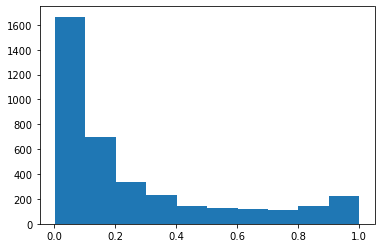

In [274]:
plt.hist(yHat[:, 1])

In [275]:
ypred = (yHat[:, 1] >= 0.5)

In [276]:
fpr, tpr, _ = roc_curve(y_test, yHat[:,1])
rocauc = auc(fpr, tpr)

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      3616
         1.0       0.22      0.86      0.36       189

    accuracy                           0.84      3805
   macro avg       0.61      0.85      0.63      3805
weighted avg       0.95      0.84      0.88      3805



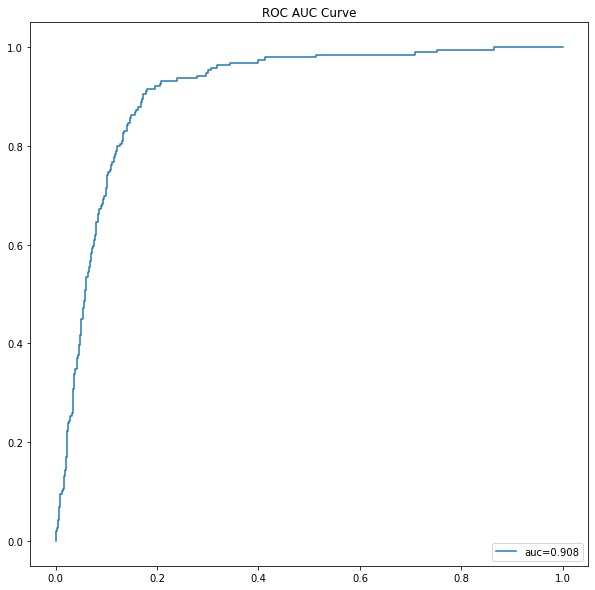

In [277]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(y_test, ypred))

#### Majority Class Undersampling

In [278]:
data.shape

(12683, 79)

In [279]:
data['crrt'].value_counts(dropna=False)

0.0    12052
1.0      631
Name: crrt, dtype: int64

In [280]:
nocrrt, crrt = data['crrt'].value_counts()

In [281]:
nocrrt_df = data[data['crrt'] == 0].reset_index(drop=True)
nocrrt_df_under = nocrrt_df.sample(n=crrt, random_state=2022)

In [282]:
crrt_df = data[data['crrt'] == 1].reset_index(drop=True)

In [283]:
under_sampled = pd.concat([crrt_df, nocrrt_df_under], axis=0).sample(frac=1)

In [284]:
under_sampled['crrt'].value_counts()

1.0    631
0.0    631
Name: crrt, dtype: int64

In [285]:
test_under, under_ytest, under_yHat = train_predict_lr(under_sampled, columns, numerical, categorical)

{'min_spo2': -0.36324088665616555, 'max_spo2': 0.10102085625615852, 'nanmin_valuenum_Albumin': -0.19654653305821623, 'nanmin_valuenum_Creatinine': -0.13137917820291614, 'nanmin_valuenum_Hematocrit': -0.24548001649986434, 'nanmin_valuenum_Potassium': 0.07105960300028491, 'nanmin_valuenum_Potassium, Whole Blood': -0.4395945480473974, 'nanmin_valuenum_Urea Nitrogen': -0.34530522696435173, 'nanmin_valuenum_pH': -1.3384433791557149, 'nanmax_valuenum_Albumin': 0.4760219884390385, 'nanmax_valuenum_Creatinine': 1.7325560124044086, 'nanmax_valuenum_Hematocrit': 0.06539789510745565, 'nanmax_valuenum_Hematocrit, Calculated': -0.13535495511864395, 'nanmax_valuenum_Potassium': 0.34923833201074506, 'nanmax_valuenum_Potassium, Whole Blood': 0.7715629541105542, 'nanmax_valuenum_Urea Nitrogen': 0.25641683034013024, 'nanmax_valuenum_pH': 1.869504080827901, 'ckd': -0.09093266553825384, 'dm': 0.012736054763572152, 'hypertension': -0.040011464726229254, 'heartfailure': 0.09622173195880927}


(array([75., 50., 26., 24., 15., 17., 19., 33., 41., 79.]),
 array([0.00298963, 0.10269067, 0.2023917 , 0.30209274, 0.40179377,
        0.50149481, 0.60119585, 0.70089688, 0.80059792, 0.90029895,
        0.99999999]),
 <BarContainer object of 10 artists>)

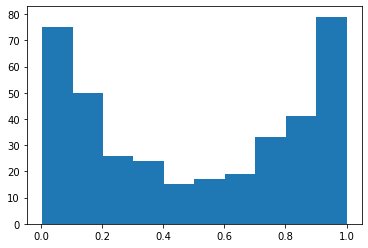

In [286]:
plt.hist(under_yHat[:, 1])

In [287]:
fpr, tpr, _ = roc_curve(under_ytest, under_yHat[:,1])
rocauc = auc(fpr, tpr)

In [288]:
ypred_under = (under_yHat[:, 1] >= 0.5)

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       189
         1.0       0.85      0.84      0.84       190

    accuracy                           0.84       379
   macro avg       0.84      0.84      0.84       379
weighted avg       0.84      0.84      0.84       379



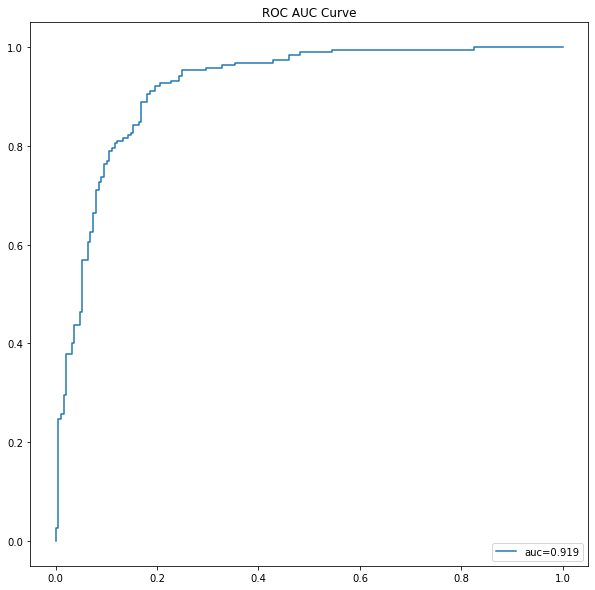

In [289]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(under_ytest, ypred_under))

In [290]:
# Stratify by AKI stage.
test_under['prediction'] = under_yHat[:, 1]

/tmp/ipykernel_4619/532204791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['prediction'] = under_yHat[:, 1]


Text(0.5, 1.0, 'Performance by AKI')

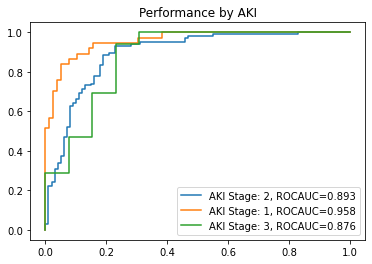

In [291]:
# Plot ROC curves for AKI stratified by stage.
for aki in test_under['aki_stage'].unique():
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AKI Stage: {aki}, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by AKI")

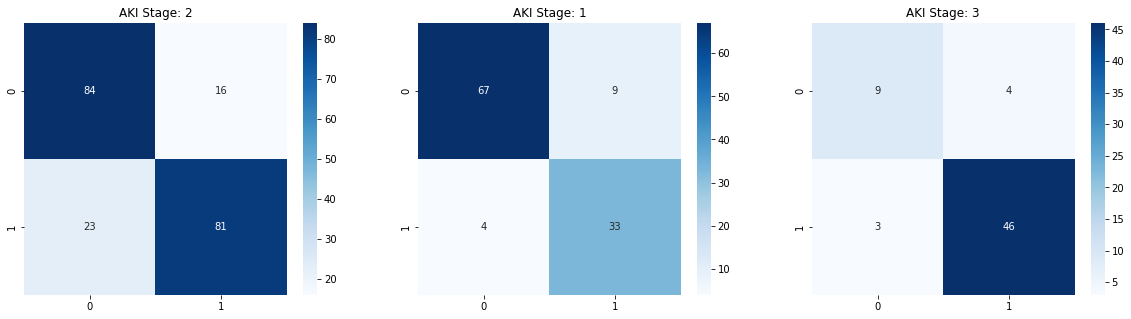

In [316]:
# Confusion matrices.
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, aki in enumerate(test_under['aki_stage'].unique()):
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    ypred = (ypred >= 0.5)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, ax=ax[i], cmap='Blues')
    ax[i].set_title(f'AKI Stage: {aki}')

#### Cross Validation undersampled

In [319]:
under_sampled.shape

(1262, 79)

In [321]:
# Leave out 20% as test set post CV. 
train, test = train_test_split(under_sampled, test_size=0.2, random_state=2022)

In [ ]:
kf = KFold(n_splits=5)
for train, test in kf.split(X):